# Импорт библиотек и чтение данных

In [5]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import pickle
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    fbeta_score,
    average_precision_score,
    PrecisionRecallDisplay)
import shap
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_parquet('/kaggle/input/fraud-imto/transaction_fraud_data.parquet')
exchange_rates = pd.read_parquet('/kaggle/input/fraud-imto/historical_currency_exchange.parquet')

# Анализ данных

In [7]:
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [5]:
exchange_rates.head()

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


In [6]:
min(exchange_rates['date']), max(exchange_rates['date'])

(datetime.date(2024, 9, 30), datetime.date(2024, 10, 30))

In [8]:
df['date'] = df['timestamp'].dt.date

In [8]:
df['is_fraud'].sum() / df.shape[0] 

0.19972818498066347

In [9]:
df.groupby(by='customer_id')['is_fraud'].sum().sort_values(ascending=False)

customer_id
CUST_91730    801
CUST_24836    753
CUST_87928    751
CUST_81009    748
CUST_77434    745
             ... 
CUST_20522    200
CUST_65274    200
CUST_84709    200
CUST_83747    200
CUST_51975    200
Name: is_fraud, Length: 4869, dtype: int64

In [10]:
(df.groupby(by='customer_id')['is_fraud'].sum() / df.groupby(by='customer_id')['is_fraud'].count()).sort_values(ascending=False)

customer_id
CUST_69293    0.200000
CUST_72733    0.200000
CUST_22184    0.200000
CUST_71117    0.200000
CUST_70997    0.200000
                ...   
CUST_43488    0.199207
CUST_62385    0.199207
CUST_94560    0.199207
CUST_84246    0.199203
CUST_40909    0.199203
Name: is_fraud, Length: 4869, dtype: float64

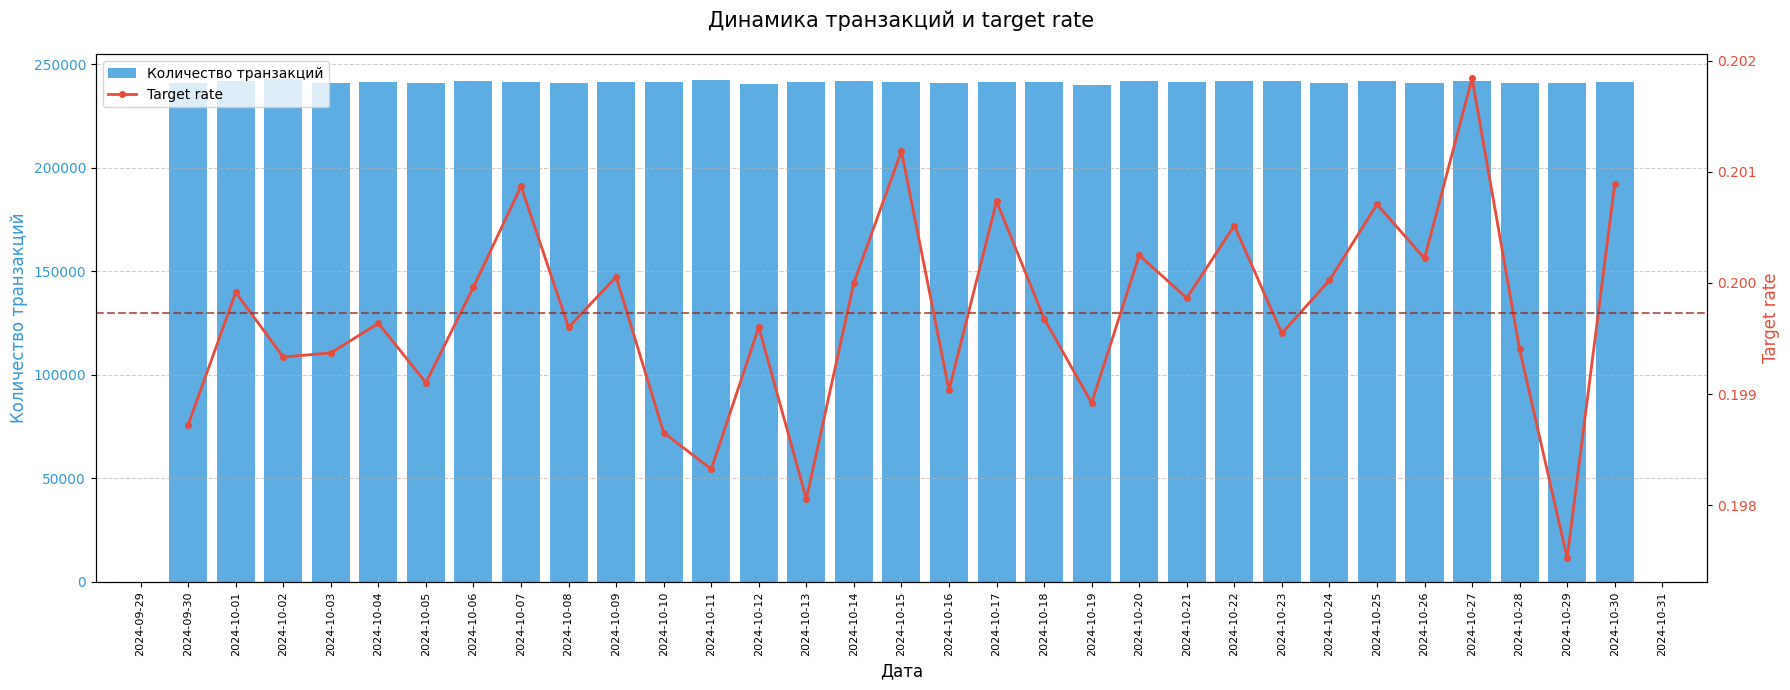

In [11]:
daily_data = df.groupby('date').agg(
    transaction_count=('transaction_id', 'count'),
    fraud_rate=('is_fraud', 'mean')
).reset_index()

full_date_range = pd.date_range(
    start=daily_data['date'].min(),
    end=daily_data['date'].max(),
    freq='D'
)

daily_data = daily_data.set_index('date').reindex(full_date_range).fillna({
    'transaction_count': 0,
    'fraud_rate': 0  
}).reset_index().rename(columns={'index': 'date'})

fig, ax1 = plt.subplots(figsize=(18, 7))

ax1.bar(
    daily_data['date'], 
    daily_data['transaction_count'], 
    color='#3498DB', 
    alpha=0.8, 
    label='Количество транзакций'
)
ax1.set_xlabel('Дата', fontsize=12)
ax1.set_ylabel('Количество транзакций', color='#3498DB', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#3498DB')
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(
    daily_data['date'], 
    daily_data['fraud_rate'],
    color='#E74C3C', 
    marker='o',
    markersize=4,
    linewidth=2,
    label='Target rate'
)
ax2.set_ylabel('Target rate', color='#E74C3C', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#E74C3C')

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.setp(ax1.xaxis.get_ticklabels(), 
         rotation=90,
         ha='center',
         fontsize=8)

avg_fraud = df['is_fraud'].mean()
ax2.axhline(y=avg_fraud, color='#922B21', linestyle='--', alpha=0.7)

plt.title('Динамика транзакций и target rate', fontsize=15, pad=20)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Построение модели

### Подготовка данных для обучения: генерация новых признаков, разбиение данных на выборки

In [9]:
#парсинг составной фичи
df['last_hour_num_transactions'] = df['last_hour_activity'].apply(lambda x: x['num_transactions'])
df['last_hour_total_amount'] = df['last_hour_activity'].apply(lambda x: x['total_amount'])
df['last_hour_unique_merchants'] = df['last_hour_activity'].apply(lambda x: x['unique_merchants'])
df['last_hour_unique_countries'] = df['last_hour_activity'].apply(lambda x: x['unique_countries'])
df['last_hour_max_single_amount'] = df['last_hour_activity'].apply(lambda x: x['max_single_amount'])

In [10]:
exchange_rates.columns

Index(['date', 'AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'JPY', 'MXN', 'NGN', 'RUB',
       'SGD', 'USD'],
      dtype='object')

In [11]:
#приведение amount к USD
tmp = exchange_rates.melt(
    id_vars=['date'],
    value_vars=['AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'JPY', 'MXN', 'NGN', 'RUB', 'SGD', 'USD'],
    var_name='currency',
    value_name='exchange_rate'
)
tmp = pd.merge(df, tmp, on=['date', 'currency'], how='left')

df['amount'] = tmp['amount'] * tmp['exchange_rate']
df['last_hour_total_amount'] = tmp['last_hour_total_amount'] * tmp['exchange_rate']
df['last_hour_max_single_amount'] = tmp['last_hour_max_single_amount'] * tmp['exchange_rate']

In [12]:
#Генерация новых фичей
#Аномалия суммы (отклонение от среднего клиента)
df['amount_anomaly'] = df.groupby('customer_id')['amount'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-5)
)

# Географический риск (страны с высоким fraud_rate)
country_risk = df.groupby('country')['is_fraud'].mean()
df['country_risk'] = df['country'].map(country_risk)

In [13]:
info_cols = ['transaction_id', 'customer_id', 'card_number', 'timestamp', 'date', 'last_hour_activity', 'device_fingerprint', 'ip_address']
long_list = [col for col in list(df.columns) if col not in info_cols + ['is_fraud']]
df[df[long_list].select_dtypes(include=['bool']).columns] = df[long_list].select_dtypes(include=['bool']).astype('int')
cat_feats = list(df[long_list].select_dtypes(include=['object']).columns)
target = 'is_fraud'

In [14]:
#Разделение выборок на train/valid/out-of-sample. Деление будет происходить по клиентам 

customers = df['customer_id'].unique()
cust_train, cust_oos, _, _ = train_test_split(customers, customers, test_size=0.3, random_state=42, shuffle=True)

cust_train, cust_val, _, _ = train_test_split(cust_train, cust_train, test_size=0.3, random_state=42, shuffle=True)

In [15]:
train = df[df['customer_id'].isin(cust_train)]
val = df[df['customer_id'].isin(cust_val)]
oos = df[df['customer_id'].isin(cust_oos)]
train.shape, val.shape, oos.shape

((3647393, 31), (1588830, 31), (2247543, 31))

In [19]:
train[target].sum() / train.shape[0], val[target].sum() / val.shape[0], oos[target].sum() / oos.shape[0]

(0.19972923126189035, 0.19973502514428856, 0.19972165159910177)

In [16]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(train[cat_feats])
train[cat_feats] = enc.transform(train[cat_feats])
val[cat_feats] = enc.transform(val[cat_feats])
oos[cat_feats] = enc.transform(oos[cat_feats])
tmp_df = df.copy()
tmp_df[cat_feats] = enc.transform(df[cat_feats])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
def objective(trial):
    params = {
        'random_state': 42,
        'eval_metric': 'F1',
        'verbose': -1,
        'early_stopping_rounds': 50,
        'num_leaves': trial.suggest_int('num_leaves', 63, 255),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    model = LGBMClassifier(**params)
    
    model.fit(train[long_list], train[target], eval_set=(val[long_list], val[target]))
    preds = model.predict_proba(val[long_list])[:, 1]
    
    metric = average_precision_score(val[target], preds)

    return metric

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-08-04 20:47:21,014] A new study created in memory with name: no-name-55c86cc0-2ca6-4bba-b246-e71af4db955f
[I 2025-08-04 20:52:49,961] Trial 0 finished with value: 0.9908778575421878 and parameters: {'num_leaves': 146, 'max_depth': 9, 'learning_rate': 0.055349897569225044, 'n_estimators': 557, 'subsample': 0.892521944518624, 'reg_alpha': 0.16047040307052246, 'reg_lambda': 0.12198833337365014, 'min_child_samples': 40}. Best is trial 0 with value: 0.9908778575421878.
[I 2025-08-04 20:55:18,366] Trial 1 finished with value: 0.9760310957289986 and parameters: {'num_leaves': 100, 'max_depth': 10, 'learning_rate': 0.010247755530977039, 'n_estimators': 299, 'subsample': 0.8830867148663599, 'reg_alpha': 4.7106290557649055, 'reg_lambda': 0.1760157080094147, 'min_child_samples': 58}. Best is trial 0 with value: 0.9908778575421878.
[I 2025-08-04 20:58:45,583] Trial 2 finished with value: 0.989247069389519 and parameters: {'num_leaves': 65, 'max_depth': 13, 'learning_rate': 0.04028258874815

In [17]:
study.best_trial

FrozenTrial(number=7, state=1, values=[0.9910936923912651], datetime_start=datetime.datetime(2025, 8, 4, 21, 12, 36, 29995), datetime_complete=datetime.datetime(2025, 8, 4, 21, 17, 53, 395957), params={'num_leaves': 244, 'max_depth': 15, 'learning_rate': 0.048536803568043484, 'n_estimators': 477, 'subsample': 0.8163132954967649, 'reg_alpha': 0.27159797785204914, 'reg_lambda': 5.883132296316321, 'min_child_samples': 71}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=255, log=False, low=63, step=1), 'max_depth': IntDistribution(high=16, log=False, low=8, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=600, log=False, low=50, step=1), 'subsample': FloatDistribution(high=0.9, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'min_

In [18]:
params = study.best_params
params['random_state'] = 42
params['eval_metric'] = 'F1'
params['verbose'] = -1
params['early_stopping_rounds'] = 50


In [19]:
model = LGBMClassifier(**params)
    
model.fit(train[long_list], train[target], eval_set=(val[long_list], val[target]))
preds = model.predict_proba(oos[long_list])[:, 1]
    
metric = average_precision_score(oos[target], preds)
print('pr-auc', metric)
metric = 2*roc_auc_score(oos[target], preds) - 1
print('gini', metric)

pr-auc 0.9910723921214809
gini 0.9937986071664333


In [20]:
with open('/kaggle/working/model_long_list.pickle', 'wb') as f:
    pickle.dump(model, f)

<Axes: xlabel='feature importance', ylabel='feature name'>

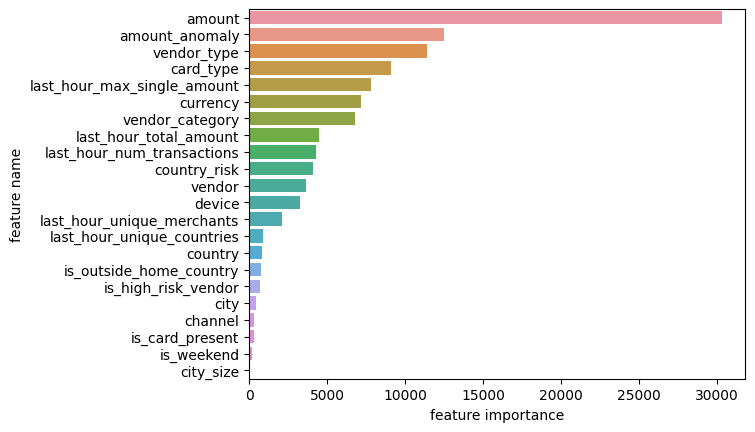

In [21]:
feature_importance = pd.DataFrame({'feature importance': model.feature_importances_, 'feature name': model.feature_name_}).sort_values(by='feature importance', ascending=False)
sns.barplot(feature_importance, y='feature name', x='feature importance')

In [22]:
# feature_importance = feature_importance['feature name'].to_list()
# short_list = feature_importance[:13]
short_list=['amount',
            'amount_anomaly',
            'vendor_type',
            'card_type',
            'last_hour_max_single_amount',
            'currency',
            'vendor_category',
           'last_hour_total_amount',
           'last_hour_num_transactions',
           'country_risk',
           'vendor',
           'device',
           'last_hour_unique_merchants']

In [23]:
def objective(trial):
    params = {
        'random_state': 42,
        'eval_metric': 'F1',
        'verbose': -1,
        'early_stopping_rounds': 50,
        'num_leaves': trial.suggest_int('num_leaves', 63, 255),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    model = LGBMClassifier(**params)
    
    model.fit(train[short_list], train[target], eval_set=(val[short_list], val[target]))
    preds = model.predict_proba(val[short_list])[:, 1]
    
    metric = average_precision_score(val[target], preds)

    return metric

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-08-04 21:29:10,449] A new study created in memory with name: no-name-14581e7b-4a40-448a-a49d-7bca8e198cd5
[I 2025-08-04 21:31:18,611] Trial 0 finished with value: 0.9817152075978366 and parameters: {'num_leaves': 131, 'max_depth': 12, 'learning_rate': 0.08383026242140632, 'n_estimators': 371, 'subsample': 0.7961396897981461, 'reg_alpha': 0.2982506081820784, 'reg_lambda': 0.2021663426435182, 'min_child_samples': 24}. Best is trial 0 with value: 0.9817152075978366.
[I 2025-08-04 21:34:18,578] Trial 1 finished with value: 0.9772282103076657 and parameters: {'num_leaves': 77, 'max_depth': 16, 'learning_rate': 0.028889826728381928, 'n_estimators': 431, 'subsample': 0.7025562201128439, 'reg_alpha': 0.23536560337237536, 'reg_lambda': 3.7917073534180448, 'min_child_samples': 64}. Best is trial 0 with value: 0.9817152075978366.
[I 2025-08-04 21:36:06,853] Trial 2 finished with value: 0.9741832388189204 and parameters: {'num_leaves': 100, 'max_depth': 14, 'learning_rate': 0.0293309707835

In [25]:
study.best_trial

FrozenTrial(number=0, state=1, values=[0.9817152075978366], datetime_start=datetime.datetime(2025, 8, 4, 21, 29, 10, 451731), datetime_complete=datetime.datetime(2025, 8, 4, 21, 31, 18, 611166), params={'num_leaves': 131, 'max_depth': 12, 'learning_rate': 0.08383026242140632, 'n_estimators': 371, 'subsample': 0.7961396897981461, 'reg_alpha': 0.2982506081820784, 'reg_lambda': 0.2021663426435182, 'min_child_samples': 24}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=255, log=False, low=63, step=1), 'max_depth': IntDistribution(high=16, log=False, low=8, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=600, log=False, low=50, step=1), 'subsample': FloatDistribution(high=0.9, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'min_

In [19]:
# params = study.best_params
params = {'num_leaves': 131,
          'max_depth': 12,
          'learning_rate': 0.08383026242140632,
          'n_estimators': 371,
          'subsample': 0.7961396897981461,
          'reg_alpha': 0.2982506081820784,
          'reg_lambda': 0.2021663426435182,
          'min_child_samples': 24,
          'random_state': 42,
        'eval_metric': 'F1',
        'verbose': -1,
        'early_stopping_rounds': 50,
         }

In [ ]:
model = LGBMClassifier(**params)

model.fit(train[short_list], train[target], eval_set=(val[short_list], val[target]))
preds = model.predict_proba(oos[short_list])[:, 1]
    
metric = average_precision_score(oos[target], preds)
print('pr-auc', metric)
metric = 2*roc_auc_score(oos[target], preds) - 1
print('gini', metric)

In [ ]:
with open('/kaggle/working/model_short_list.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
feature_importance = pd.DataFrame({'feature importance': model.feature_importances_, 'feature name': model.feature_name_}).sort_values(by='feature importance', ascending=False)
sns.barplot(feature_importance, y='feature name', x='feature importance')

In [ ]:
feature_importance = feature_importance['feature name'].to_list()
short_list = feature_importance[:4]

In [ ]:
def objective(trial):
    params = {
        'random_state': 42,
        'eval_metric': 'F1',
        'verbose': -1,
        'early_stopping_rounds': 50,
        'num_leaves': trial.suggest_int('num_leaves', 63, 255),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    model = LGBMClassifier(**params)
    
    model.fit(train[short_list], train[target], eval_set=(val[short_list], val[target]))
    preds = model.predict_proba(val[short_list])[:, 1]
    
    metric = average_precision_score(val[target], preds)

    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

In [33]:
study.best_trial

FrozenTrial(number=6, state=1, values=[0.8251341296079532], datetime_start=datetime.datetime(2025, 8, 4, 22, 6, 11, 148443), datetime_complete=datetime.datetime(2025, 8, 4, 22, 9, 40, 698039), params={'num_leaves': 195, 'max_depth': 10, 'learning_rate': 0.04234915901808617, 'n_estimators': 512, 'subsample': 0.6023594939406451, 'reg_alpha': 0.1961773400933955, 'reg_lambda': 7.015959529718649, 'min_child_samples': 87}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=255, log=False, low=63, step=1), 'max_depth': IntDistribution(high=16, log=False, low=8, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=600, log=False, low=50, step=1), 'subsample': FloatDistribution(high=0.9, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'min_chi

In [34]:
params = study.best_params

In [35]:
params['random_state'] = 42
params['eval_metric'] = 'F1'
params['verbose'] = -1
params['early_stopping_rounds'] = 50

In [36]:
model = LGBMClassifier(**params)

model.fit(train[long_list], train[target], eval_set=(val[long_list], val[target]))
preds = model.predict_proba(oos[long_list])[:, 1]
    
metric = average_precision_score(oos[target], preds)
print('pr-auc', metric)
metric = 2*roc_auc_score(oos[target], preds) - 1
print('gini', metric)

pr-auc 0.9908806147680947
gini 0.993686775712977


<Axes: xlabel='feature importance', ylabel='feature name'>

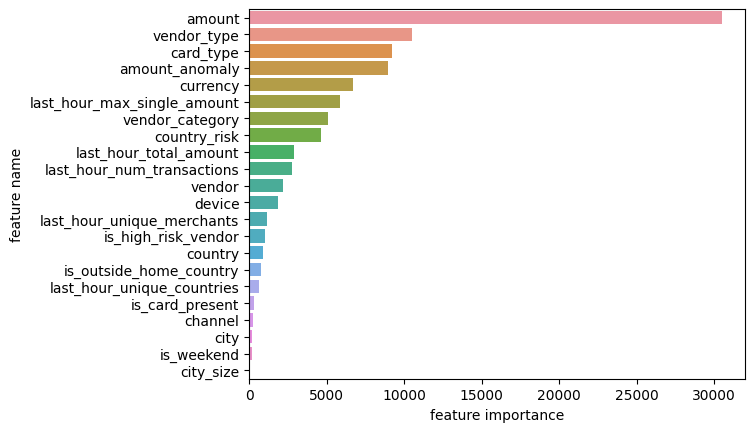

In [37]:
feature_importance = pd.DataFrame({'feature importance': model.feature_importances_, 'feature name': model.feature_name_}).sort_values(by='feature importance', ascending=False)
sns.barplot(feature_importance, y='feature name', x='feature importance')

In [38]:
with open('/kaggle/working/model_super_short_list.pickle', 'wb') as f:
    pickle.dump(model, f)

In [35]:
amount_check = df[['amount', target]].sort_values(by='amount', ascending=False)

In [41]:
tmp = amount_check[amount_check['amount'] > amount_check['amount'].median()]
tmp['is_fraud'].sum(), df['is_fraud'].sum(), tmp['is_fraud'].sum() / df['is_fraud'].sum()

(1093565, 1494719, 0.7316191203831623)

In [42]:
tmp = amount_check[amount_check['amount'] < amount_check['amount'].median()]
tmp['is_fraud'].sum(), df['is_fraud'].sum(), tmp['is_fraud'].sum() / df['is_fraud'].sum()

(401154, 1494719, 0.26838087961683765)

In [63]:
percs = df['amount'].describe(percentiles=[.25, .5, .75, .80, .85, .90, .95, .98, .99])

In [77]:
tmp = amount_check[amount_check['amount'] < percs.loc['50%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (3741883, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.26838087961683765
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.10720645193876986


In [78]:
tmp = amount_check[amount_check['amount'] > percs.loc['75%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (1870942, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.3198694871745124
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.2555477401223555


In [79]:
tmp = amount_check[amount_check['amount'] > percs.loc['90%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (748377, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.14196715235438903
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.28354826511236986


In [80]:
tmp = amount_check[amount_check['amount'] > percs.loc['99%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (74838, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.04062904131144382
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.811472781207408


In [73]:
scam_df = df[df['is_fraud'] == True]
unscam_df = df[df['is_fraud'] == False]

In [75]:
print(scam_df['amount'].mean())
print(unscam_df['amount'].mean())
print(scam_df['amount'].mean() / unscam_df['amount'].mean())

154411983.05383274
34829320.74042159
4.433390596521971


In [11]:
tmp_df

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,last_hour_activity,is_fraud,date,last_hour_num_transactions,last_hour_total_amount,last_hour_unique_merchants,last_hour_unique_countries,last_hour_max_single_amount,amount_anomaly,country_risk
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,5.0,4.0,84.0,2.203131e+02,4.0,10.0,...,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30,1197,2.502855e+07,105,12,1.438629e+06,-0.141316,0.069351
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,1.0,5.0,80.0,1.830917e+04,1.0,1.0,...,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30,509,1.093166e+08,100,12,2.798364e+07,-0.132320,0.371060
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,3.0,12.0,101.0,1.462551e+07,5.0,5.0,...,"{'num_transactions': 332, 'total_amount': 3916...",False,2024-09-30,332,5.583719e+09,97,12,2.640802e+08,-0.119564,0.071279
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,2.0,8.0,31.0,9.103682e+02,0.0,0.0,...,"{'num_transactions': 764, 'total_amount': 2201...",False,2024-09-30,764,3.177858e+07,105,12,2.967862e+06,-0.108206,0.075805
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,4.0,9.0,58.0,1.209749e+09,7.0,7.0,...,"{'num_transactions': 218, 'total_amount': 4827...",True,2024-09-30,218,8.056052e+09,88,12,1.931114e+09,6.351447,0.351360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483761,TX_58a762fa,CUST_11344,377055034743699,2024-10-30 23:59:58.926575,6.0,10.0,3.0,1.174495e+03,9.0,9.0,...,"{'num_transactions': 1, 'total_amount': 1521.7...",False,2024-10-30,1,2.014278e+03,1,1,1.174498e+03,-0.137127,0.063557
7483762,TX_dabcf671,CUST_38961,373625915641065,2024-10-30 23:59:58.950801,3.0,12.0,48.0,3.289511e+02,3.0,3.0,...,"{'num_transactions': 0, 'total_amount': 356.06...",False,2024-10-30,0,3.289553e+02,0,0,3.289553e+02,-0.177093,0.069143
7483763,TX_ab567eb4,CUST_75576,6702342842796660,2024-10-30 23:59:58.972155,3.0,12.0,48.0,5.188151e+02,9.0,9.0,...,"{'num_transactions': 0, 'total_amount': 391.96...",False,2024-10-30,0,5.188159e+02,0,0,5.188159e+02,-0.105424,0.063557
7483764,TX_5ae61846,CUST_82508,374615717295581,2024-10-30 23:59:58.996608,6.0,10.0,103.0,6.017100e+02,10.0,11.0,...,"{'num_transactions': 2, 'total_amount': 1474.5...",False,2024-10-30,2,1.474510e+03,2,1,6.017100e+02,-0.157225,0.074615


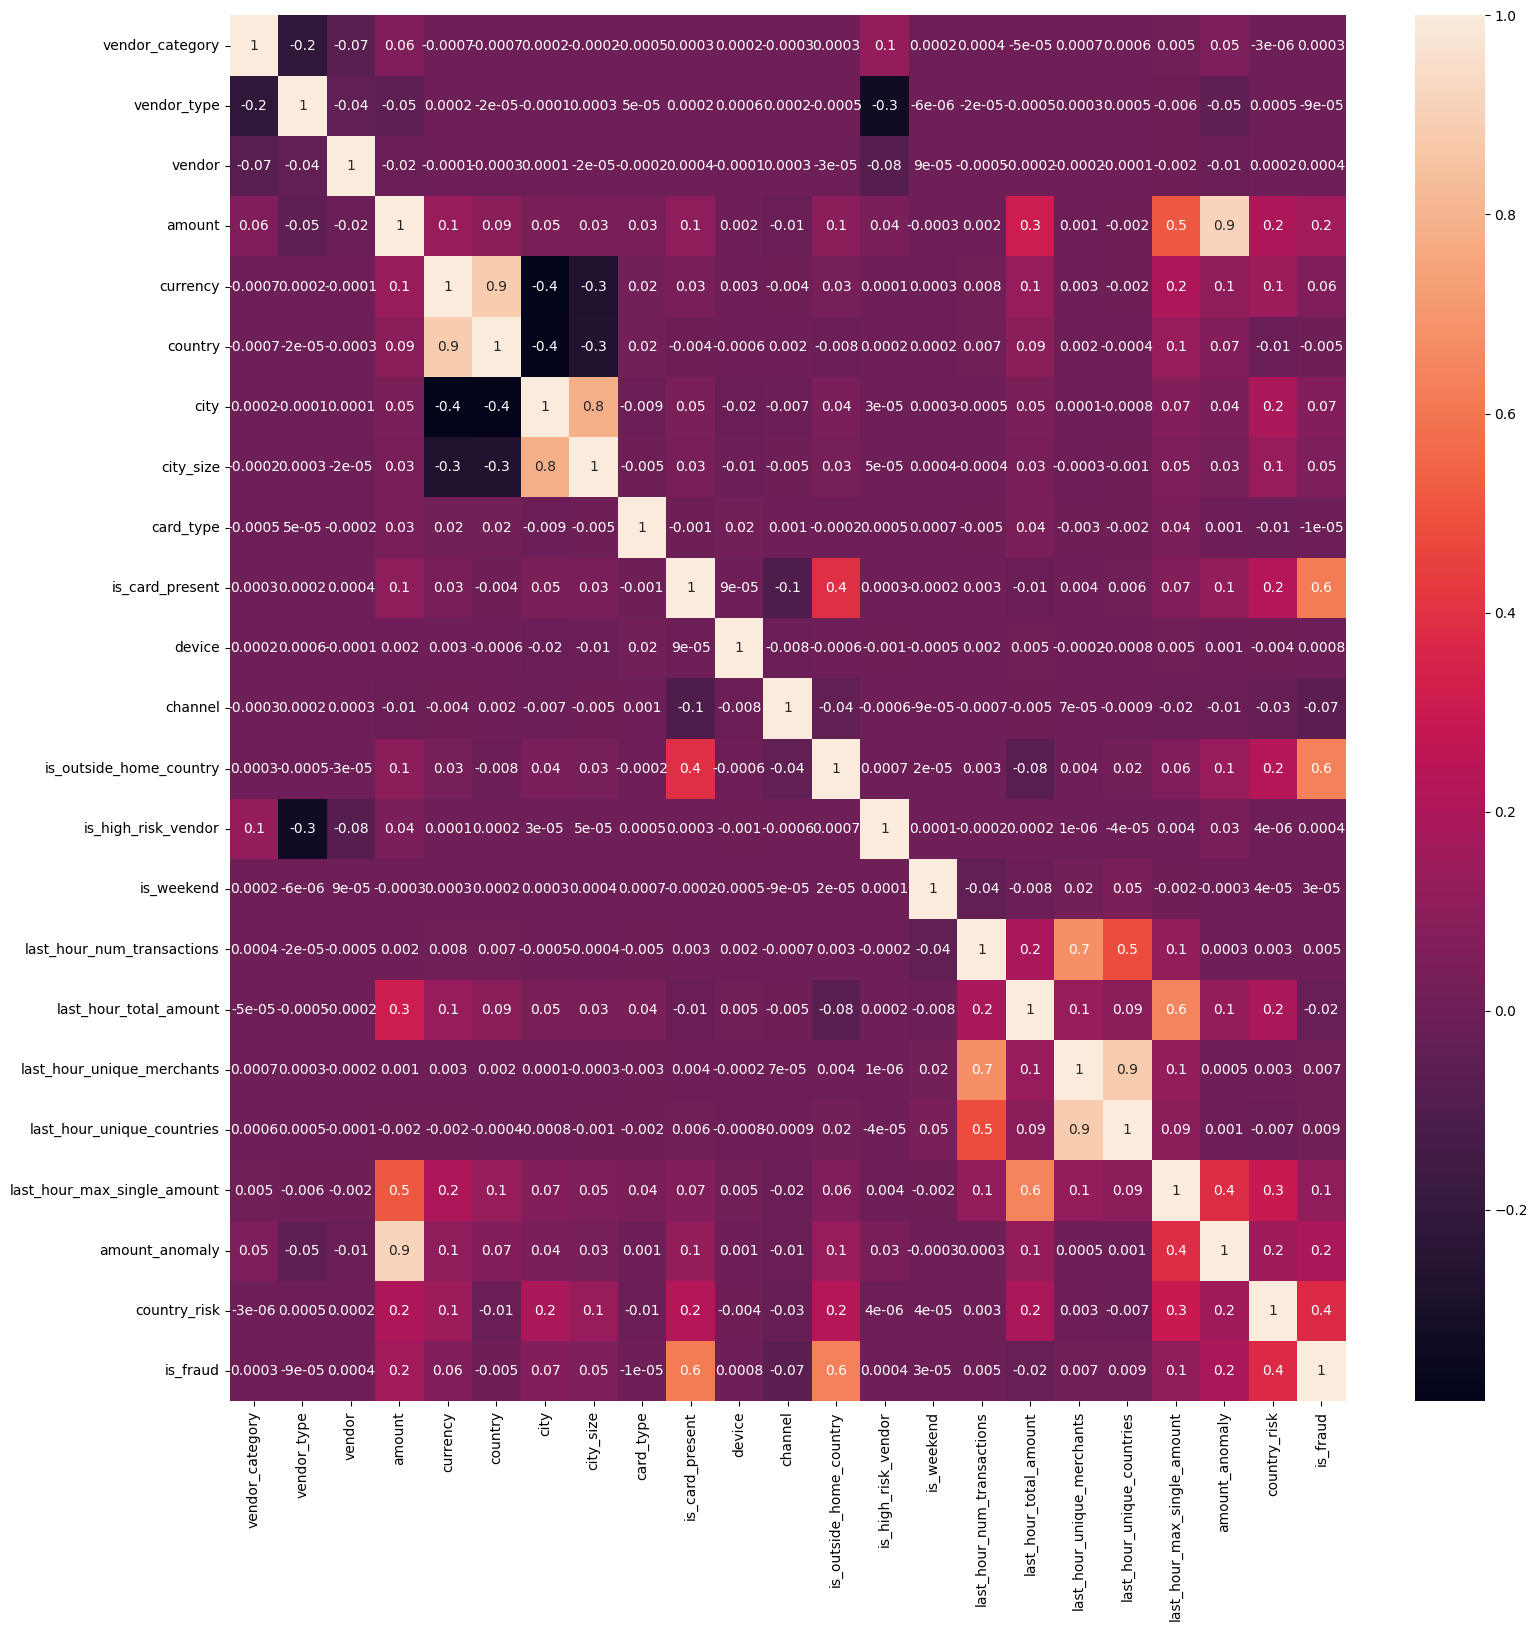

In [14]:
figsize = (18, 18)

fig, ax = plt.subplots(figsize=figsize)
# feats = list(df.select_dtypes(exclude='object').columns)
# feats.remove('timestamp')
# feats.remove('card_number')
hmap = sns.heatmap(tmp_df[long_list + [target]].corr(), annot = True, fmt='.1g', ax=ax)
plt.show()

In [85]:
scam_df['last_hour_num_transactions'].mean(), unscam_df['last_hour_num_transactions'].mean()

(412.67047920043836, 408.26253308748454)